<a href="https://colab.research.google.com/github/hsgarciad/EnvDatSci22/blob/master/DataScienceProject_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1. Mount Google Drive working folder

In [1]:
#Attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 2. Import libraries, modules, and packages necessary to work with geospatial data

In [2]:
#Import libraries and packages
%matplotlib inline

import sys
from glob import glob
from osgeo import ogr, gdal, gdal_array
from osgeo import gdalconst
import subprocess

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline
import numpy as np

import seaborn as sns

!pip install geopandas
import geopandas as gpd
!pip install pycrs
import pycrs
import fiona
from fiona.crs import from_epsg
from shapely.geometry import box
from shapely.geometry import Point
import shapely.geometry as geoms

!pip install rasterio
import rasterio as rio
from rasterio.plot import show
import rasterio.warp
import rasterio.shutil
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import plotting_extent
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
from rasterio import plot

!pip install rasterstats
import rasterstats as rs
!pip install georasters
import georasters as gr

!pip install earthpy
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy as et

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.3 MB/s 
     |████████████████████████████████| 7.8 MB 44.6 MB/s 
     |████████████████████████████████| 16.6 MB 61.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32703 sha256=4566bdeef4cd0005051ace403874684f0842a2467a547288735e40b0679eecd0
  Stored in directory: /root/.cache/pip/wheels/c1/e9/f3/19ecf82bebc5cdaba5c2a83f673f7b9b09c26fbc9b57534a2e
Successfully built pycrs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 861 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 7.5 MB/s 
Looking in indexes: https://pypi.or

In [3]:
def print_class_count(classes):
    '''
    Prints total number and number of pixel per class

    Parameter: array (pixel with assigned classes)
    '''
    n_samples = (classes > 0).sum()
    print('There are {n} training pixel'.format(n=n_samples))

    labels = np.unique(classes[classes > 0])
    class_min, class_max = int(labels.min()), int(labels.max())

    print ('Number of pixel per class:')
    for i in range (class_min, class_max+1):
        count = len(classes[classes==i])
        print ('Class {k}: {c}'.format(k=i, c=count))

def get_class_count_list(classes):
    '''
    Creates list with number of pixel per class

    Parameter: array (pixel with assigned classes)
    Return: List 
    '''
    list_counts = []
    labels = np.unique(classes[classes > 0])
    class_min, class_max = int(labels.min()), int(labels.max())
    for i in range (class_min, class_max+1):
        count = len(classes[classes==i])
        list_counts.append(count)

    return list_counts
from imblearn.under_sampling import RandomUnderSampler

Step 2.1 I loaded up the raster datasets with rasterio but then I decided to use gdal

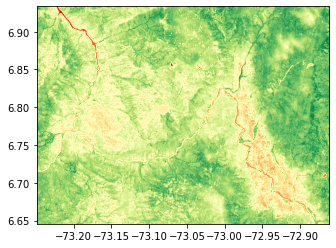

In [ ]:
#ndvi_path = '/content/drive/MyDrive/Data/ClassProject/NDVI_chicamocha.tif'
#ndvi_chica=rio.open(ndvi_path)
#train_path = '/content/drive/MyDrive/Data/ClassProject/training_land.tif'
#training_chica=rio.open(train_path)
#show(ndvi_chica,cmap='RdYlGn')

Step 3. Here I load up the raster data (NDVI and Land cover) of the Chicamocha River Canyon and proceed to convert them into an array

In [4]:
#Load NDVI and training data using gdal and create a gdal array
gdal.UseExceptions()
gdal.AllRegister()
ndvi_chica = gdal.Open('/content/drive/MyDrive/Data/ClassProject/NDVI_chicamocha.tif', gdal.GA_ReadOnly)
training_chica = gdal.Open('/content/drive/MyDrive/Data/ClassProject/training_land.tif', gdal.GA_ReadOnly)

Step 4. Tranform imported rasters into arrays

In [5]:
#Since the two rasters have different shapes, I need to fix this first.
tc = training_chica.GetGeoTransform()
nc = ndvi_chica.GetGeoTransform()

SmlMaxX = tc[0] + (tc[1] * training_chica.RasterXSize)
SmlMinY = tc[3] + (tc[5] * training_chica.RasterYSize)
Xoff = int((tc[0] - nc[0])/nc[1]) # cols to skip
Yoff = int((tc[3] - nc[3])/nc[5]) # rows to skip
Cols = int((SmlMaxX - tc[0])/nc[1])
Rows = int((SmlMinY - tc[3])/nc[5])

# print out some numbers so you can check manually
print("X offset {}, Y offset {}".format(Xoff,Yoff))
print("Xmax {}, Ymin {}".format(SmlMaxX,SmlMinY))
print("Reading {} cols, {} rows".format(Cols,Rows))

train_ar = ndvi_chica.GetRasterBand(1).ReadAsArray().astype(np.uint8)
ndvi_ar = ndvi_chica.ReadAsArray(Xoff,Yoff,Cols,Rows)

ndvi_f = np.zeros((ndvi_ar.shape[0], ndvi_ar.shape[1], 1),
               gdal_array.GDALTypeCodeToNumericTypeCode(ndvi_chica.GetRasterBand(1).DataType))
ndvi_f[:, :, 0] = ndvi_ar
train_f = training_chica.GetRasterBand(1).ReadAsArray().astype(np.uint8)

X offset 105, Y offset 14
Xmax -72.87124601624717, Ymin 6.646365292615102
Reading 4099 cols, 3182 rows


Step 3.1 Display the converted datasets

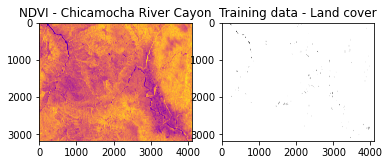

In [6]:
plt.subplot(121)
plt.imshow(ndvi_f[:, :, 0], cmap=plt.cm.plasma)
plt.title('NDVI - Chicamocha River Cayon')

plt.subplot(122)
plt.imshow(train_f, cmap=plt.cm.Greys)
plt.title('Training data - Land cover')
plt.show()

In [7]:
n_samples = (train_f > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(train_f[train_f > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

We have 81978 samples
The training data include 7 classes: [1 2 3 4 5 6 7]


Step 4. Save X and y arrays and prepare the predictor and predictand arrays.

In [8]:
X = ndvi_f[train_f > 0, :]
y = train_f[train_f > 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8,
                        random_state=1,stratify=y)

In [9]:
#joining the training datasat (X_train and y_train) in one array
df_train = np.column_stack((X_train, y_train))
#print information of total number and number of pixels per class in training dataset
print_class_count(df_train[:,1][df_train[:,1] > 0]) #df_train[:,26] contains the classified pixels

There are 65582 training pixel
Number of pixel per class:
Class 1: 22918
Class 2: 2608
Class 3: 20949
Class 4: 5306
Class 5: 2904
Class 6: 9090
Class 7: 1807


Step 5. Train the Random Forest algorithm

In [20]:
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)
from sklearn.ensemble import RandomForestClassifier

In [11]:
# Initialize our model with 1000 trees
rf = RandomForestClassifier(n_estimators=1000, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

In [13]:
print('The prediction accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

The prediction accuracy is: 60.278367366854525%


Step 6. Here we prepare the raster scene resulting from the Random Forest training as an array of two dimensions

In [15]:
new_shape = (ndvi_f.shape[0] * ndvi_f.shape[1], ndvi_f.shape[2])

img_as_array = ndvi_f[:, :, :].reshape(new_shape)
print("Reshaping of X Arrays in two dimensions: {o} -> {n}".format(o=ndvi_f.shape,
                                          n=img_as_array.shape))

Reshaping of X Arrays in two dimensions: (3182, 4099, 1) -> (13043018, 1)


Step 6.1 Classification of each pixel and reshaping of the classified raster dataset

In [17]:
class_prediction = rf.predict(img_as_array)
class_prediction = class_prediction.reshape(ndvi_f[:, :, 0].shape)
print("Shape of final classification: {o}". format(o=class_prediction.shape))
     

Shape of final classification: (3182, 4099)


Step 7. Accuracy assessment of our Random Forest model using a confussion matrix

In [22]:
#Classification with testing dataset (X_test, y_test)
y_TestPredicted = rf.predict(X_test)
#Result accuracy assessment 
print("Accuracy score:", accuracy_score(y_test,y_TestPredicted))
print("Confusion matrix:\n", confusion_matrix(y_test,y_TestPredicted))
print("Classification report:\n", classification_report(y_test,y_TestPredicted))

Accuracy score: 0.9928031227128568
Confusion matrix:
 [[5683    0   43    4    0    0    0]
 [  10  633    9    0    0    0    0]
 [  32    4 5196    3    0    0    2]
 [   0    1    6 1320    0    0    0]
 [   0    0    0    0  726    0    0]
 [   0    0    0    0    1 2271    1]
 [   0    0    1    0    1    0  449]]
Classification report:
               precision    recall  f1-score   support

           1       0.99      0.99      0.99      5730
           2       0.99      0.97      0.98       652
           3       0.99      0.99      0.99      5237
           4       0.99      0.99      0.99      1327
           5       1.00      1.00      1.00       726
           6       1.00      1.00      1.00      2273
           7       0.99      1.00      0.99       451

    accuracy                           0.99     16396
   macro avg       0.99      0.99      0.99     16396
weighted avg       0.99      0.99      0.99     16396



Step 8. Visualization of the classified dataset in classes

In [23]:
classes = {
    1 : ("Mesic Forest", "#964b00"),
    2 : ("Crops","#ffffff"),
    3 : ("Dry Forest", "#1f78b4"),
    4 : ("Bedrock", "#000000"),
    5 : ("Landslides", "#33a02c"),
    6 : ("Water Bodies", "#b2df8a"),
    7 : ("Human Infrastructure", "#edb60e")}

classes_colors = []
classes_labels = []

for key in classes:
    values = classes.get(key)
    label = values[0]
    color = values[1]

    classes_labels.append(label)
    classes_colors.append(color)

n_classes = class_prediction.max()

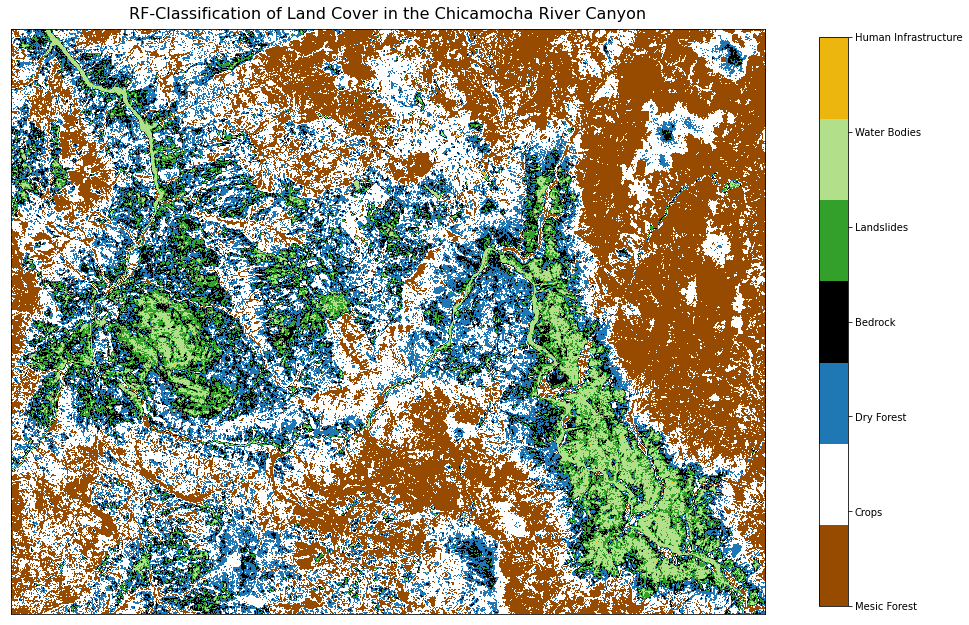

In [25]:
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={"xticks": [], "yticks": []})
cmap = plt.matplotlib.colors.ListedColormap(classes_colors, N=n_classes) #colormap
cax = ax.imshow(class_prediction,cmap=cmap)

plt.title("RF-Classification of Land Cover in the Chicamocha River Canyon", fontsize=16, pad=10)
cbar = fig.colorbar(cax, ax=ax, fraction=0.034, pad=0.065)
cbar.ax.set_yticklabels(classes_labels)
plt.savefig('/content/drive/MyDrive/Data/ClassProject/Chicamocha_Classified.png',dpi=300)
plt.show()